## importing libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,ConfusionMatrixDisplay

## Load and Prepare the Data (Manual Loading)


In [15]:
# Define column names
columns = [
    'id', 'diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

df = pd.read_csv("E:\\dataset\\wdbc.data", header=None, names=columns)

# Quick checks
print("Data shape:", df.shape)
print("Diagnosis counts:\n", df['diagnosis'].value_counts())  # B: 357, M: 212 — mild imbalance
print("Missing values:\n", df.isnull().sum())  # Should be 0

# Prepare X (features) and y (target)
X = df.drop(['id', 'diagnosis'], axis=1)  # Drop ID (useless), diagnosis (that's y)
y = df['diagnosis'].map({'M': 1, 'B': 0})  # 1 = Malignant (positive/cancer), 0 = Benign

print("Features head:\n", X.head())

Data shape: (569, 32)
Diagnosis counts:
 diagnosis
B    357
M    212
Name: count, dtype: int64
Missing values:
 id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst    

## Split the Data

In [16]:
# First split: train + val (90%) vs test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Then split train_val into train (80% total) and val (10% total)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42, stratify=y_train_val)  # 0.111 ≈ 10%/90%

print("Train shape:", X_train.shape)  # ~455 rows
print("Val shape:", X_val.shape)    # ~57 rows
print("Test shape:", X_test.shape)  # ~57 rows

Train shape: (455, 30)
Val shape: (57, 30)
Test shape: (57, 30)


### Scalling

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
X_val_scaled = scaler.transform(X_val)         # Transform val (no fit!)
X_test_scaled = scaler.transform(X_test)       # Transform test

## Train and Evaluate Baseline Model
metrics explain: Accuracy = overall correct; Precision = of predicted positive, how many true; Recall = of true positive, how many caught; F1 = balance; AUC = overall quality)

In [18]:
# Baseline
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train_scaled, y_train)

# Predict on val
y_val_pred = baseline.predict(X_val_scaled)

# Metrics
print("Baseline Val Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall:", recall_score(y_val, y_val_pred, zero_division=0))
print("F1 Score:", f1_score(y_val, y_val_pred, zero_division=0))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred))

Baseline Val Metrics:
Accuracy: 0.631578947368421
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC-ROC: 0.5


## Train and Evaluate Improved Model (Tree-Based)

In [19]:
# Improved: XGBoost with class weight for imbalance
improved = XGBClassifier(random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))  # Weight malignant higher
improved.fit(X_train_scaled, y_train)

# Predict on val (probabilities for AUC)
y_val_pred = improved.predict(X_val_scaled)
y_val_prob = improved.predict_proba(X_val_scaled)[:, 1]  # Probability of class 1

# Metrics
print("Improved Val Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_val_prob))  # Expect ~0.95+ — much better!

Improved Val Metrics:
Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9523809523809523
F1 Score: 0.975609756097561
AUC-ROC: 0.9973544973544973


## Final Evaluation on Test Set

In [20]:
# Predict on test
y_test_pred = improved.predict(X_test_scaled)
y_test_prob = improved.predict_proba(X_test_scaled)[:, 1]

# Metrics (same as above)
print("Test Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Metrics:
Accuracy: 1.0


## visualization

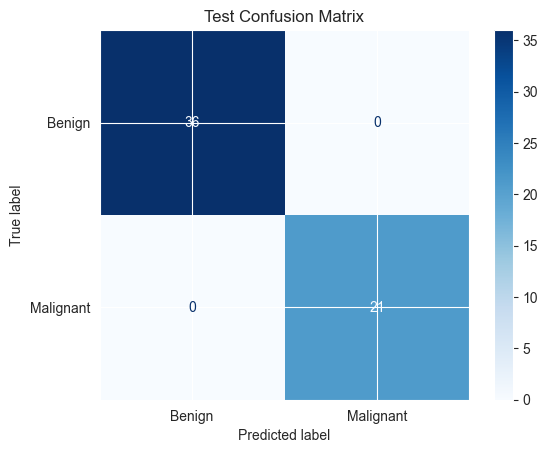

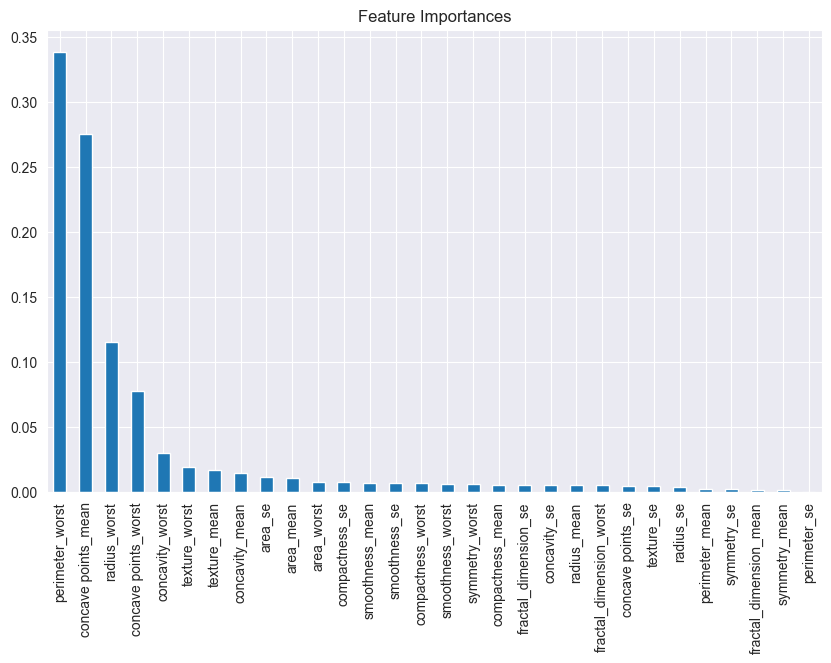

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()  # Save as image for PDF: plt.savefig('confusion_matrix.png')

# Feature Importance (built-in)
importances = pd.Series(improved.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title('Feature Importances')
plt.show()


